## Members 
- Benedictus Kent RACHMAT
- Dana AUBAKIROVA
- Diego Andres TORRES GUARIN

## Exploratory data analysis

Import the necessary libraries

In [24]:
import os
import csv
import torch
import sklearn
import platform
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import datasets, transforms

In [25]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

%load_ext autoreload
%autoreload 2

1.0.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
dotenv_path = Path('../public.env')
load_dotenv(dotenv_path=dotenv_path)

PUBLIC_DATA = os.getenv('PUBLIC_DATA')
SAMPLE_DATA = os.getenv('SAMPLE_DATA')
NEW_DATA    = os.getenv('NEW_DATA')

DATA_PATH = Path(PUBLIC_DATA)

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid", "test"]
ALL_SETS = ["train", "valid-lab", "valid", "test"]

TORCH_MODEL = Path("torch/model")

In [30]:
def number_lines(fname):
    with open(fname) as f:
        return sum(1 for l in f)
    
def fast_import(arr, fpath):
    with open(fpath) as f:
        for i, row in enumerate(csv.reader(f, delimiter=" ")):
            arr[i] = row

In [55]:
num_fts = number_lines(DATA_PATH / f"{DATA_NAME}_feat.name")

num = {
    data_set: number_lines(DATA_PATH / f"{DATA_NAME}_{data_set}.data")
    for data_set in DATA_SETS
}

xs_raw = {
    data_set: np.empty((num[data_set], num_fts))
    for data_set in DATA_SETS
}

for data_set in DATA_SETS:
    fast_import(
        xs_raw[data_set], 
        fpath=DATA_PATH / f"{DATA_NAME}_{data_set}.data"
    )
    

In [56]:
xs_raw

{'train': array([[109., 134., 112., ..., 107., 127., 102.],
        [ 68.,  73.,  66., ..., 115., 108., 100.],
        [119., 142., 122., ..., 134., 135., 140.],
        ...,
        [179., 164., 145., ..., 161., 146., 125.],
        [ 93., 113.,  88., ...,  62.,  88.,  59.],
        [133., 130., 121., ..., 114., 112.,  97.]]),
 'valid': array([[ 14.,  14.,  16., ...,  85.,  86.,  90.],
        [152., 148., 123., ..., 144., 133., 113.],
        [199., 198., 194., ...,  47.,  81.,  90.],
        ...,
        [ 24.,  25.,  29., ...,  32.,  33.,  37.],
        [ 22.,  38.,  37., ...,  26.,  38.,  38.],
        [130., 134., 137., ..., 211., 194., 178.]]),
 'test': array([[ 60.,  85., 125., ...,  65.,  89., 135.],
        [ 56.,  87.,  56., ...,  42.,  60.,  38.],
        [ 51.,  75.,  53., ...,  34.,  66.,  51.],
        ...,
        [ 63.,  71.,  60., ...,  61.,  66.,  62.],
        [ 68.,  96., 108., ..., 190., 176., 163.],
        [ 73.,  73.,  71., ..., 155., 142., 126.]])}

In [68]:
labels_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_label.name", header=None, names=["name"]
)

labels = labels_df.name.to_list()

ys_df = pd.read_csv(
    DATA_PATH / f"{DATA_NAME}_train.solution", header=None, names=["value"]
)

ys_raw = ys_df.values.squeeze()

ys_df["label"] = ys_df.value.map(labels_df.name)

Import the image using `datasets.ImageFolder` (Assuming that we have the data with image format)

In [33]:
train_folder = datasets.ImageFolder(NEW_DATA+'/train', transform=None)
train_data   = list(train_folder)

val_folder = datasets.ImageFolder(NEW_DATA+'/valid-lab', transform=None)
val_data   = list(val_folder)

shape_example = np.array(train_data[0][0])

print("Number of datapoints for training data:",len(train_data))
print("Number of datapoints for validation data:",len(val_data))
print("Shape of the image:", shape_example.shape)

Number of datapoints for training data: 4160
Number of datapoints for validation data: 1040
Shape of the image: (128, 128, 3)


Using the `train_folder` variable, we can extract the class names

In [34]:
idx_to_class = {v:k for k, v in train_folder.class_to_idx.items()}
classes      = [idx_to_class[x] for x in train_folder.targets]

df_label = pd.DataFrame(list(train_folder.class_to_idx.items()),columns = ['labels', 'code']).to_string(index=False)
print(df_label)

   labels  code
    beach     0
chaparral     1
    cloud     2
   desert     3
   forest     4
   island     5
     lake     6
   meadow     7
 mountain     8
    river     9
      sea    10
 snowberg    11
  wetland    12


Using `pandas` we could plot how many pictures we have for each label, we can conclude that chaparral has the most data among all.

In [35]:
class_counts = pd.Series(classes).value_counts()
class_counts_val = pd.Series([idx_to_class[x] for x in val_folder.targets]).value_counts()
concat_classes = pd.concat([class_counts, class_counts_val], axis=1, keys=["train","validation"])
concat_classes

,train,validation
chaparral,330,70
desert,327,73
wetland,324,76
lake,322,78
snowberg,322,78
meadow,320,80
river,320,80
forest,319,81
island,319,81
sea,319,81


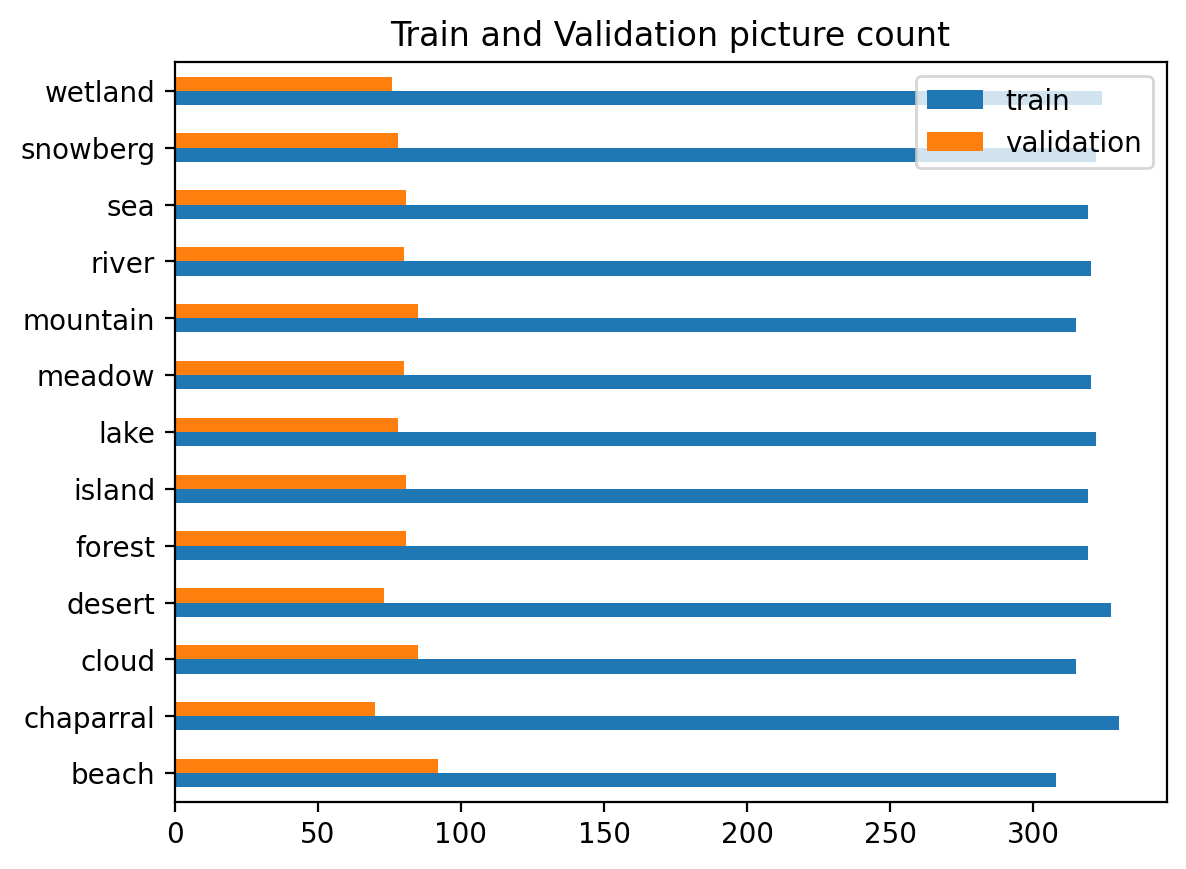

In [60]:
df = pd.DataFrame({'train': class_counts,
                   'validation': class_counts_val})
ax = df.plot.barh()
ax.set(title="Train and Validation picture count")
plt.show()

We could also calculate the probability distribution of each label 

In [37]:
training_prob = class_counts/class_counts.sum()
validation_prob = class_counts_val/class_counts_val.sum()
concat_prob = pd.concat([training_prob, validation_prob], axis=1, keys=["train","validation"])
concat_prob

,train,validation
chaparral,0.079327,0.067308
desert,0.078606,0.070192
wetland,0.077885,0.073077
lake,0.077404,0.075000
snowberg,0.077404,0.075000
meadow,0.076923,0.076923
river,0.076923,0.076923
forest,0.076683,0.077885
island,0.076683,0.077885
sea,0.076683,0.077885


In [38]:
def give_figure(label):
    ROWS, COLS = 4,4
    indices = np.random.choice(np.where(np.array(classes)==label)[0], ROWS*COLS)
    fig, axes = plt.subplots(ROWS, COLS, figsize=(20,20))
    for ax, idx in zip(axes.flatten(), indices):
        img = train_data[idx][0]
        ax.imshow(np.array(img))
        
    return fig

To see the images, we could change the parameter `label` to whatever label we want to see some of the images

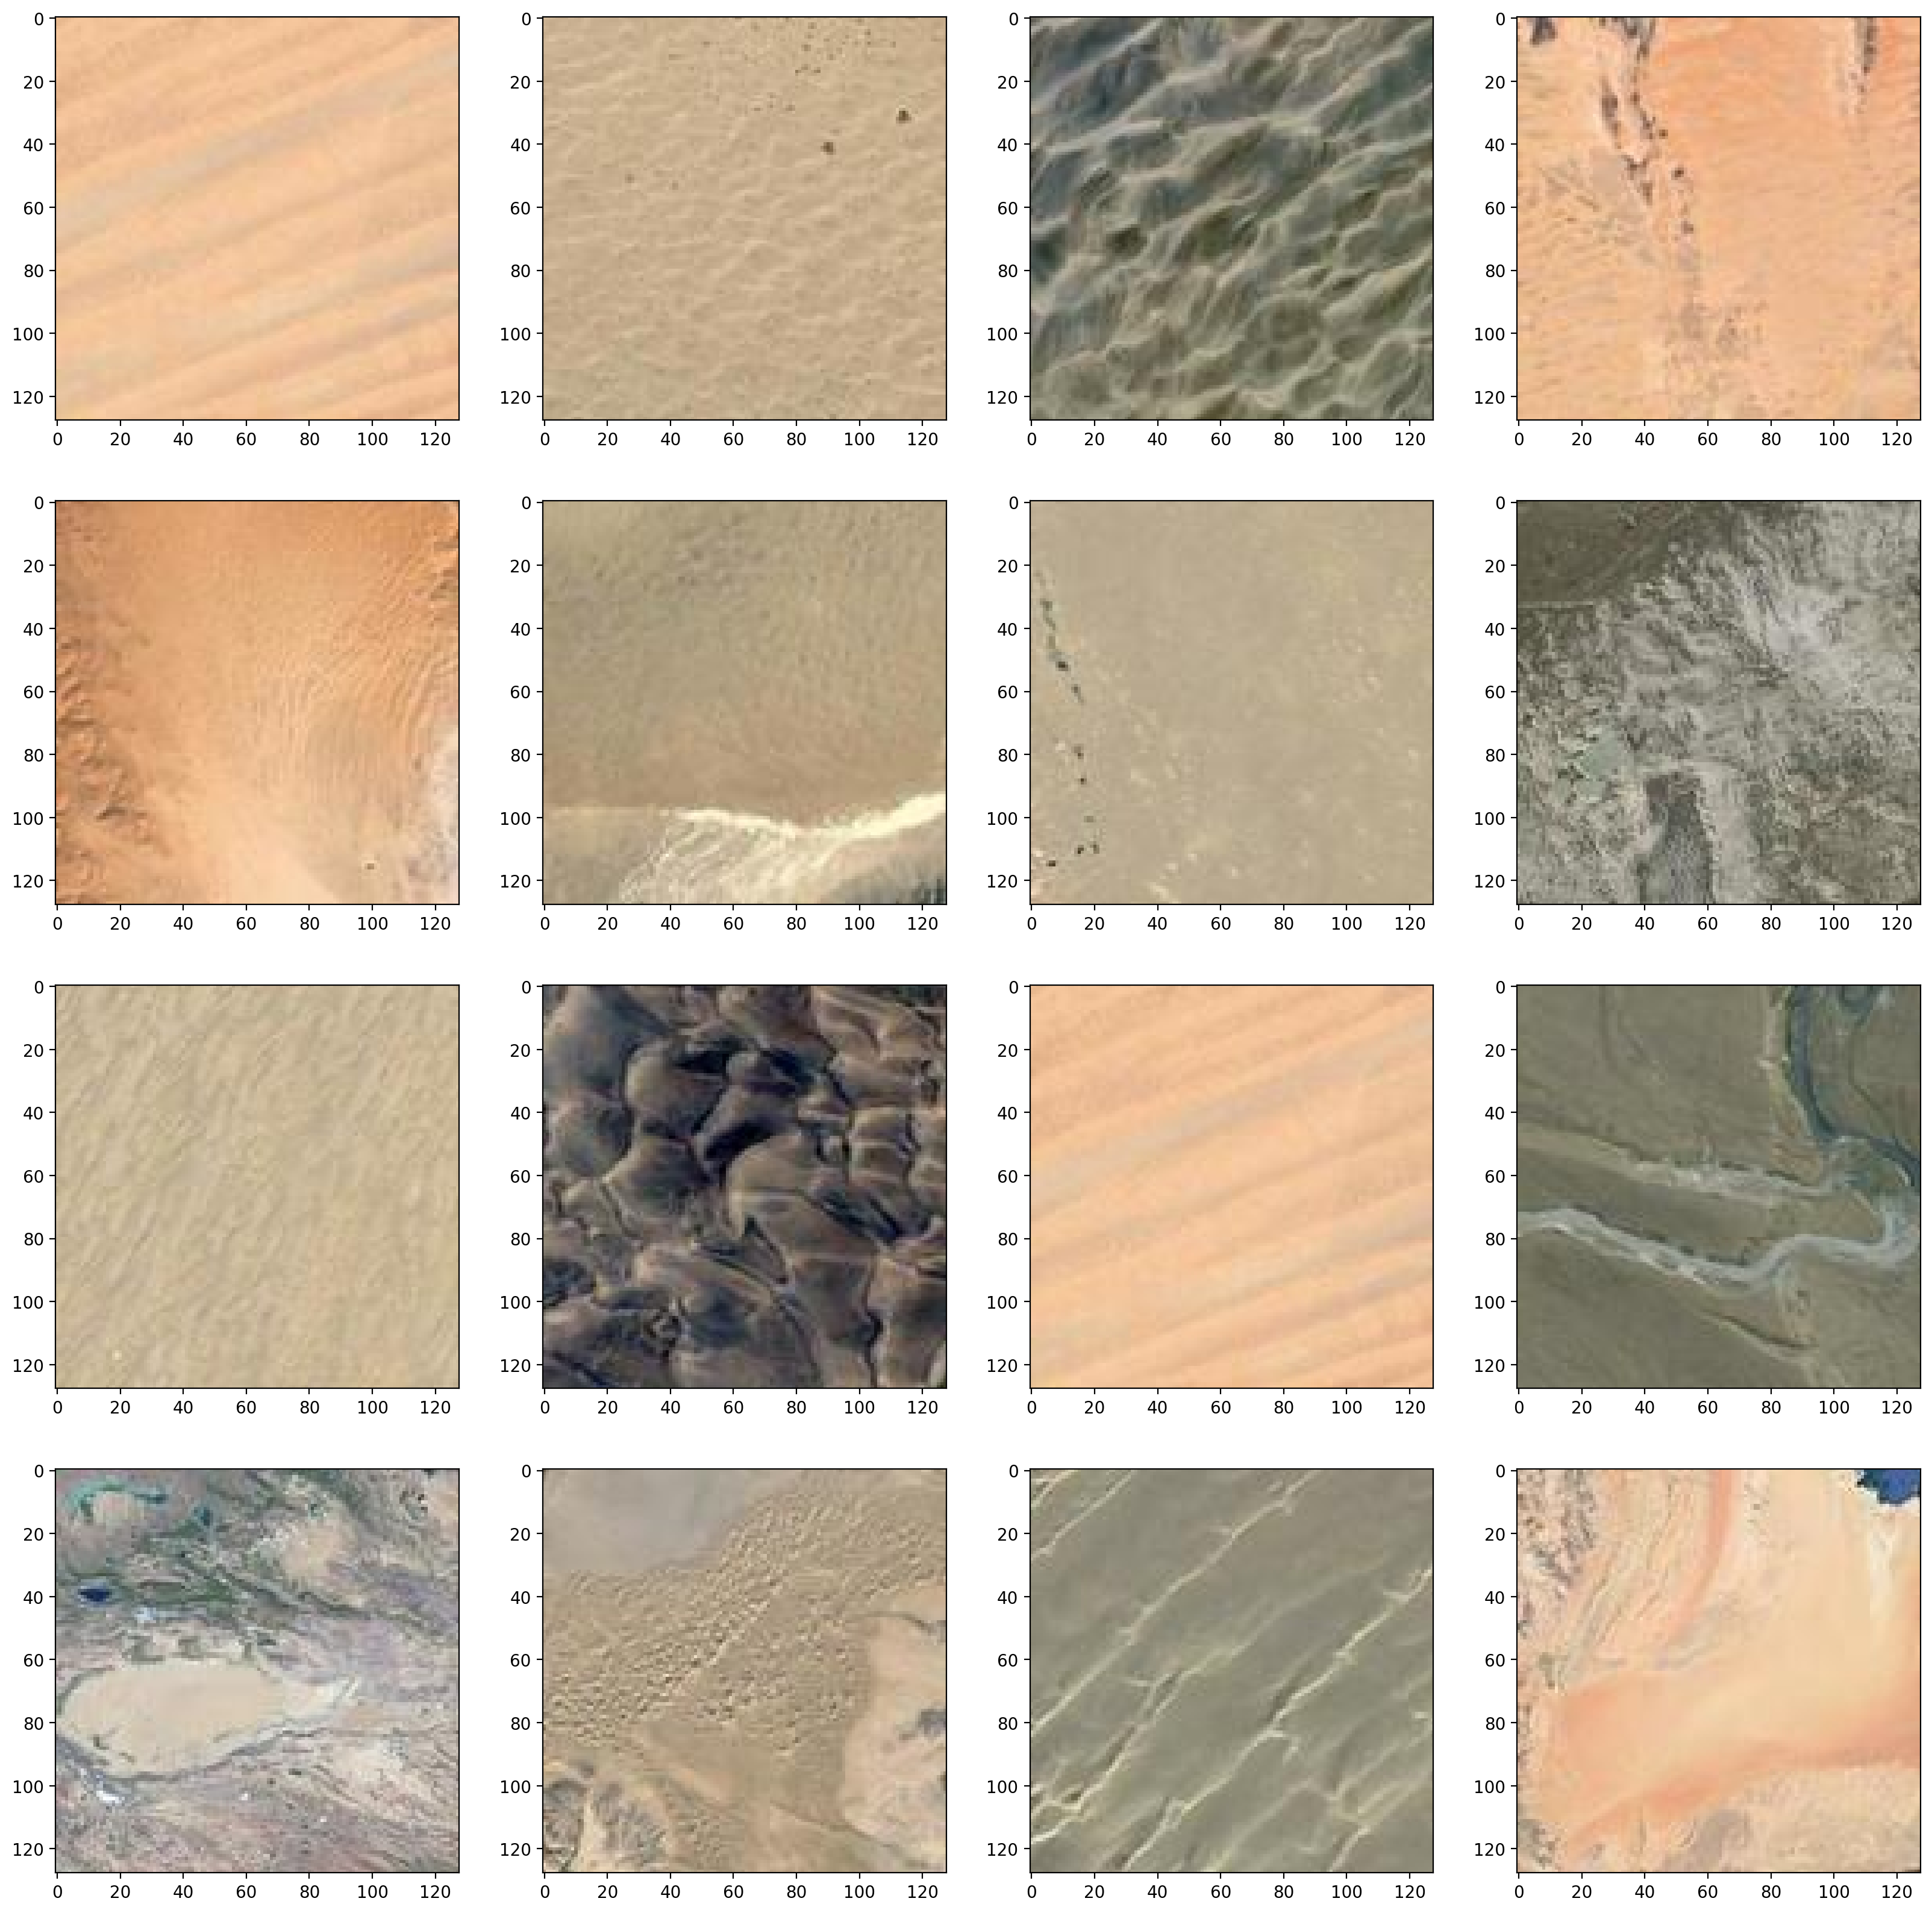

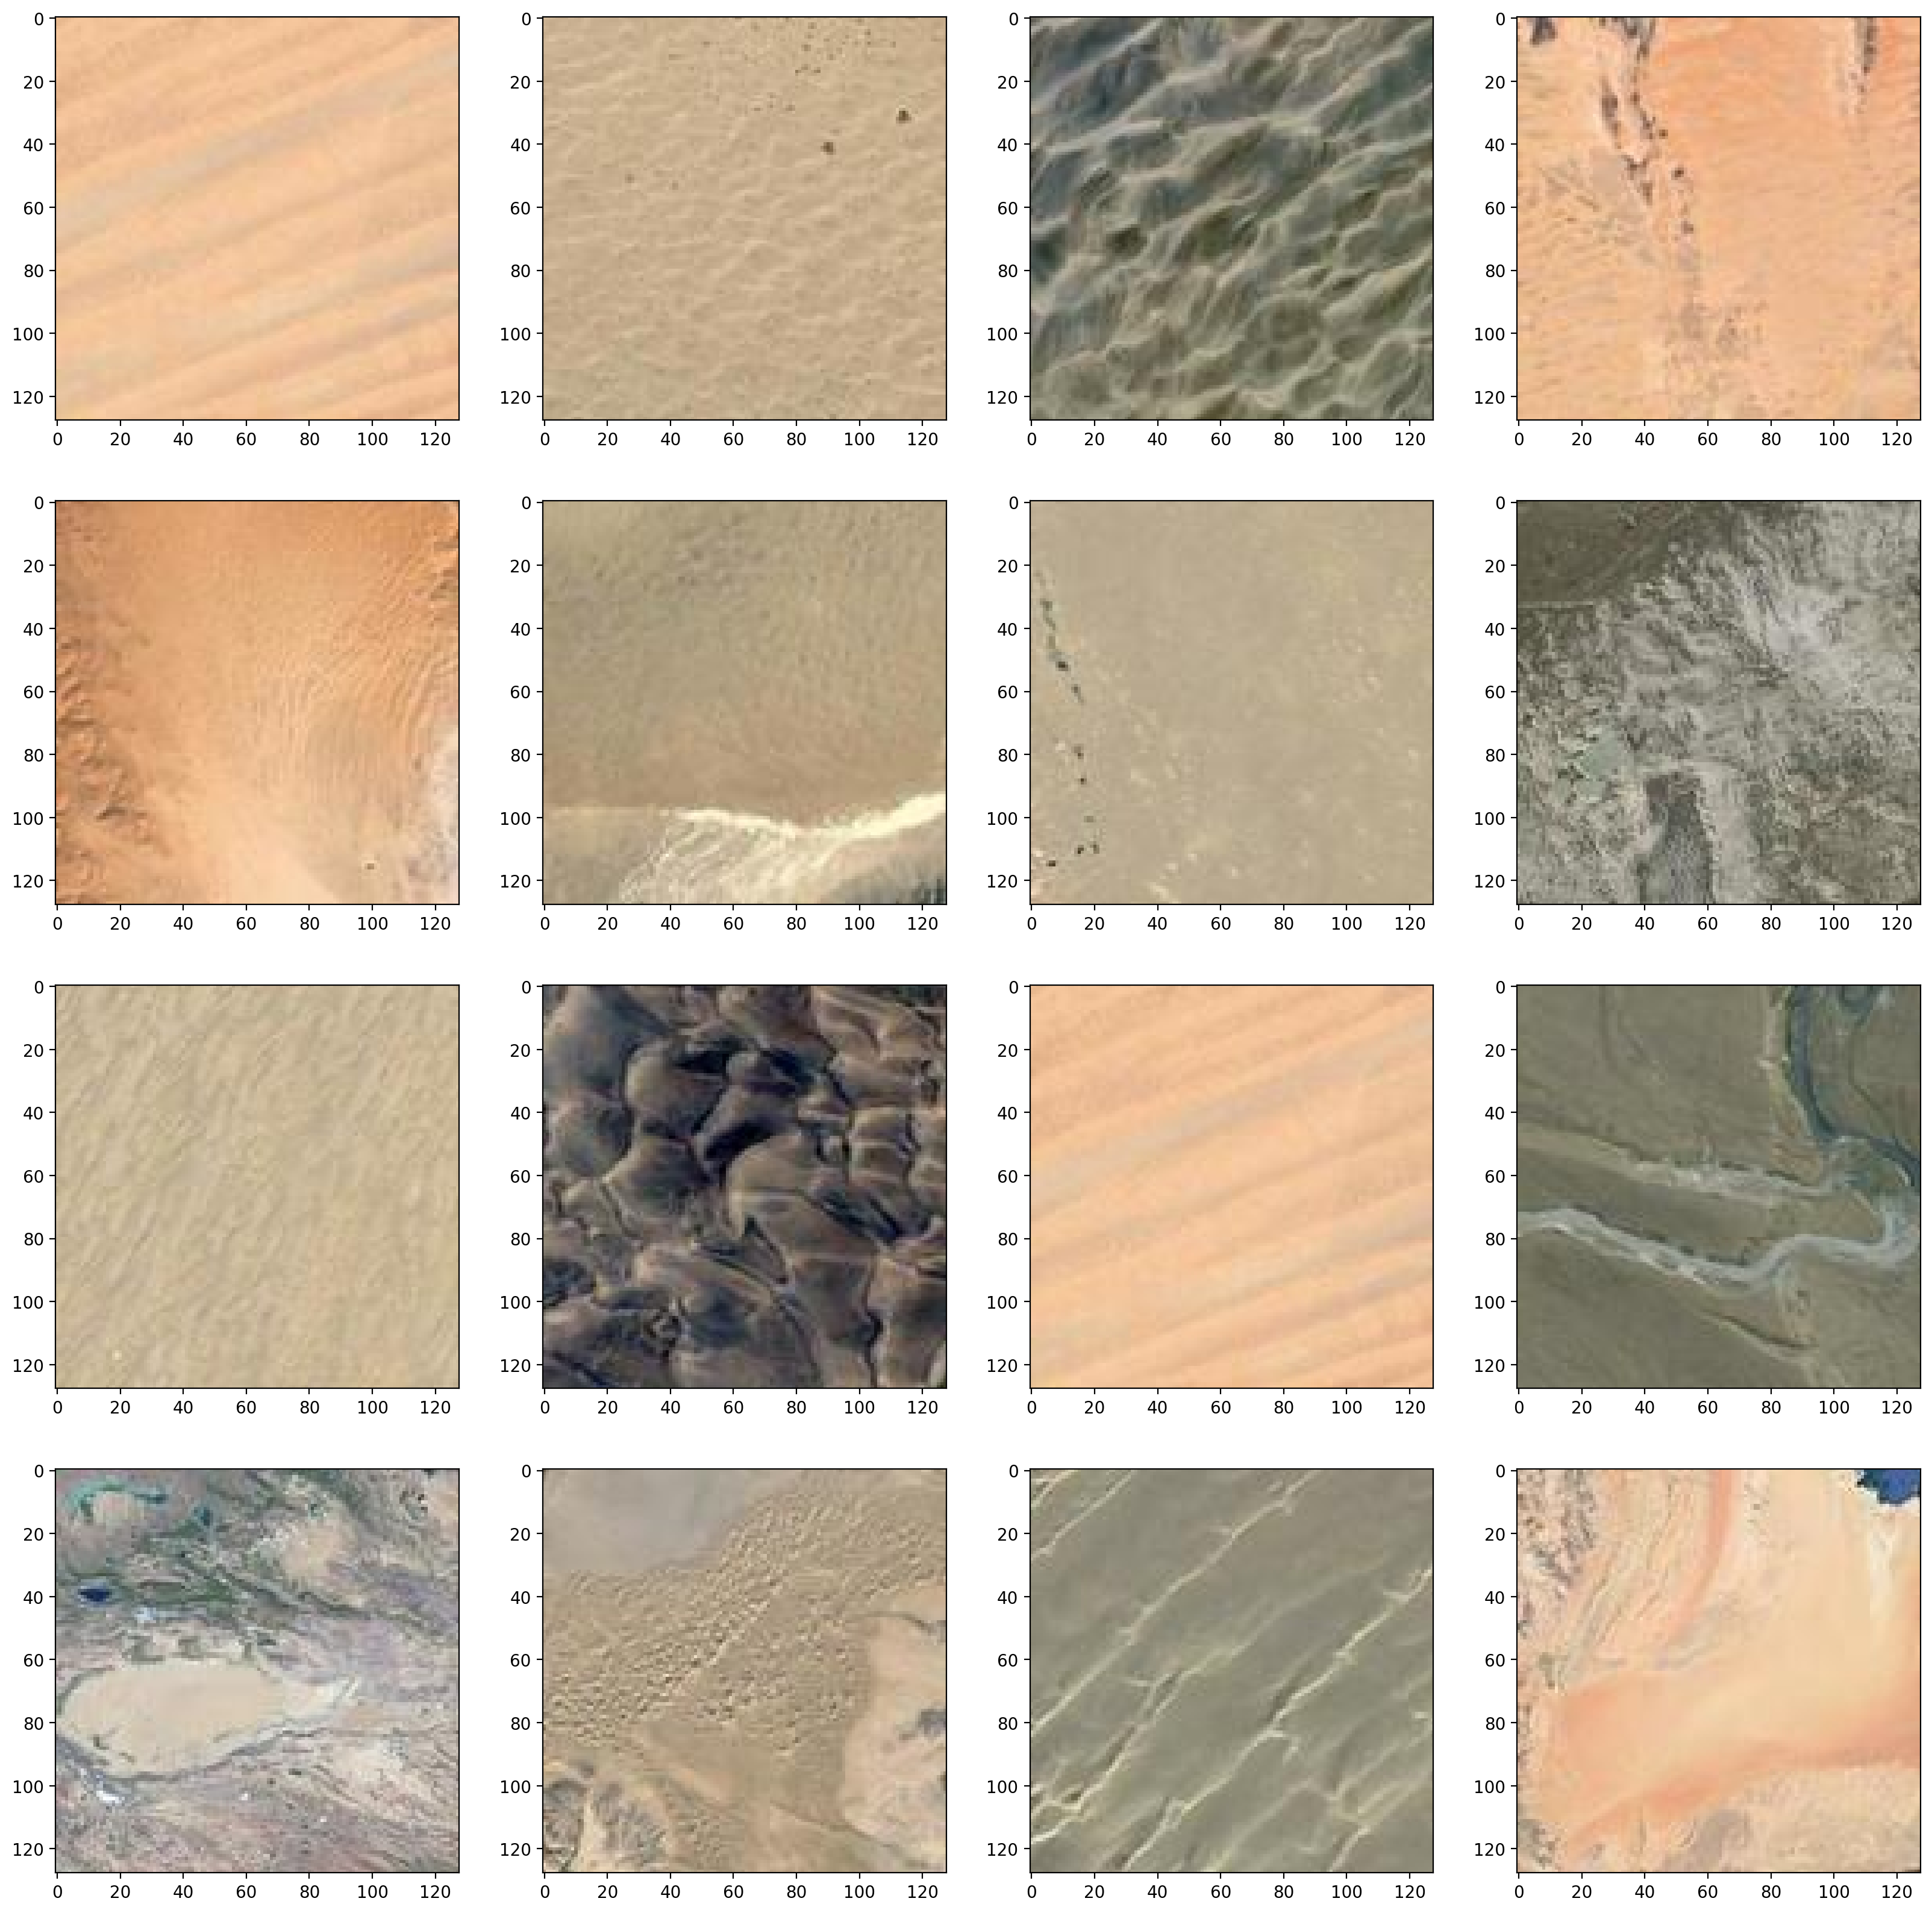

In [39]:
give_figure('desert')

For further exploratory data analysis, we could analyze the RGB color model and plot the graph 

In [40]:
data_coords = pd.DataFrame(np.zeros((len(train_data), 4)), columns=list('RGB')+['label'])
for n, (img, label) in enumerate(train_data):
    data_coords.iloc[n, :3] = np.array(img).mean(axis=(0,1))
    data_coords.iloc[n, 3] = idx_to_class[label]
    
data_coords

,R,G,B,label
0,121.233643,144.952515,122.415894,beach
1,132.344788,139.552551,129.149719,beach
2,141.629639,150.961548,138.173950,beach
3,91.528687,98.197632,95.409363,beach
4,122.109253,139.947998,139.831299,beach
...,...,...,...,...
4155,63.124084,86.420410,58.049927,wetland
4156,64.196411,68.888367,55.825623,wetland
4157,48.039917,57.498718,50.928833,wetland
4158,41.097473,45.401489,31.682678,wetland


In [41]:
data_coords[list('RGB')] = data_coords[list('RGB')]/255

In [42]:
pca = PCA(2)
transformed_coords = pca.fit_transform(data_coords[list('RGB')])
data_coords[list('xy')] = transformed_coords

In [43]:
red, green, blue = pca.transform(np.identity(3))

/usr/local/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


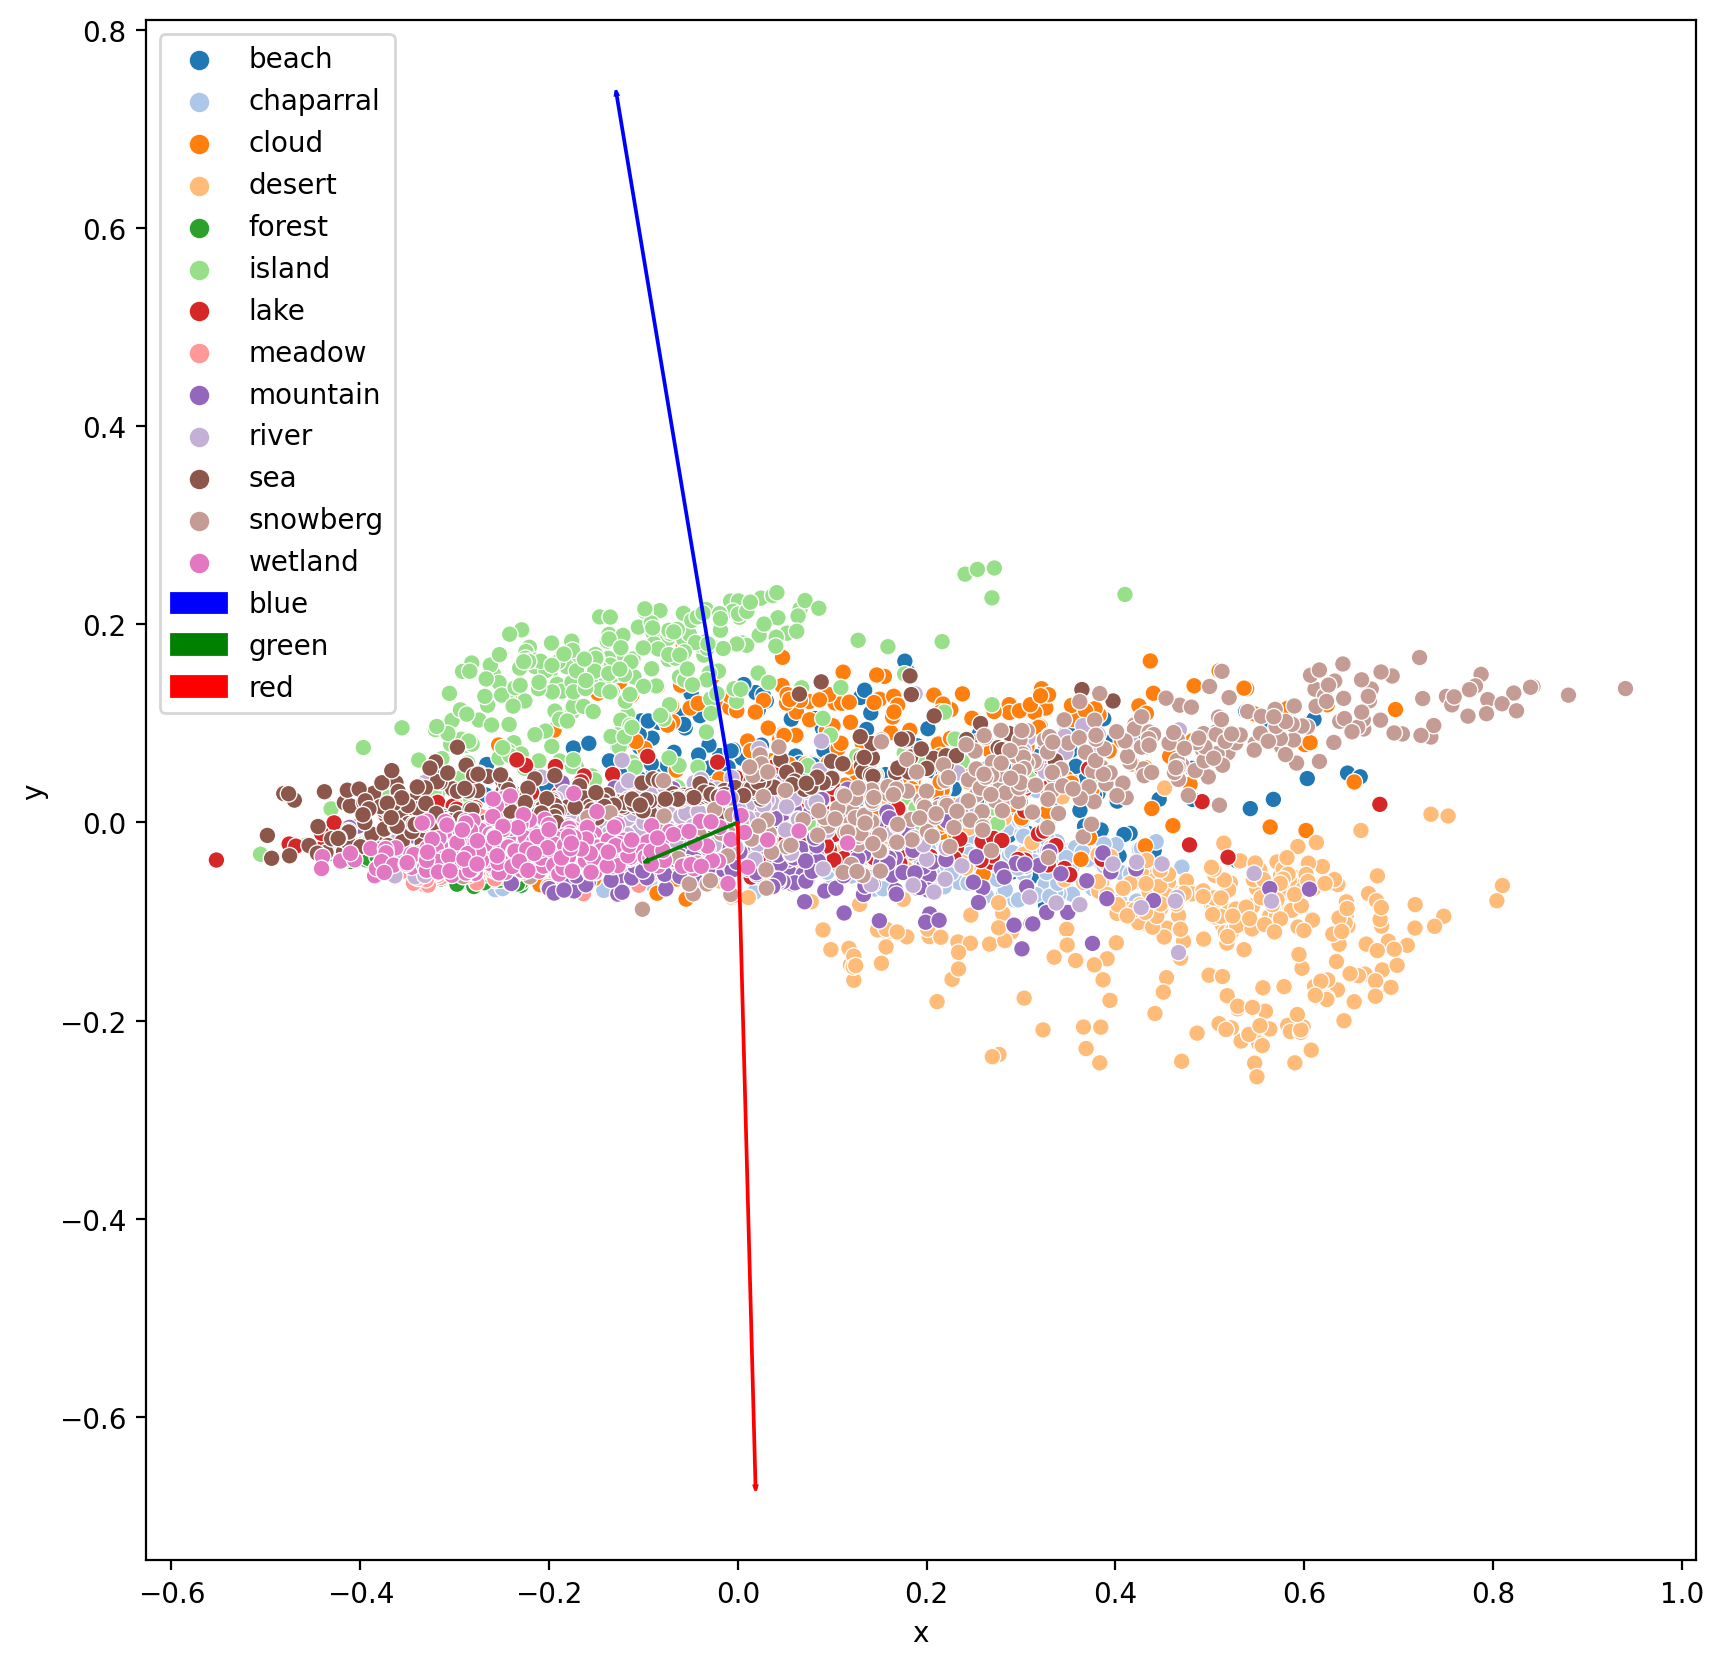

In [44]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='x', y='y', hue='label', data=data_coords, palette='tab20')
plt.arrow(0,0,*blue, color='blue', label='blue')
plt.arrow(0,0,*green, color='green', label='green')
plt.arrow(0,0,*red, color='red', label='red')
plt.legend()
plt.show()